# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# keep a copy of the original df if needed for comparison and verification
azdias_backup = azdias.copy(deep=True)

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

feat_info_backup = feat_info.copy(deep=True)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [6]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [7]:
azdias.shape

(891221, 85)

In [8]:
feat_info.shape

(85, 4)

In [9]:
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [10]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# First convert the missing_and_unknown column from string to list
# helper function str2list does the conversion
import json 

def str2list(s):
    """
        Convert feat_info['missing_or_unknown'] rows from string to list 
    """
    if not isinstance(s, str):
        return s
    
    try: 
        return json.loads(s)
    except json.JSONDecodeError:
        s = s.replace('XX', '"XX"') 
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            s = s.replace('X', '"X"')
            return json.loads(s)
    
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: str2list(x))

In [12]:
# Spreading the list values into rows for. Reference code I sused to achieve is below:
# ref: https://mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas-9849d8ff2401 

feat_info = feat_info.missing_or_unknown.apply(pd.Series)\
    .merge(feat_info, left_index = True, right_index = True)\
    .drop(["missing_or_unknown"], axis = 1)\
    .melt(id_vars = ['attribute', 'information_level', 'type'], value_name = "missing_or_unknown")\
    .drop("variable", axis = 1)\
    .dropna()

In [13]:
# Check if list has been spreded to rows
feat_info[feat_info.attribute == 'AGER_TYP']

attribute information_level         type missing_or_unknown
0   AGER_TYP            person  categorical                 -1
85  AGER_TYP            person  categorical                  0

In [14]:
# now feat_info must have more rows
feat_info.shape

(112, 4)

In [15]:
# add np.nan to azdias data frame
def impute_na(azdias, feat_info):
    
    for ix in feat_info.index:
        attr = feat_info.loc[ix, 'attribute']
        miss = feat_info.loc[ix, 'missing_or_unknown']
        azdias.loc[:, attr].replace(miss, np.nan, inplace=True)

azdias2 = azdias.copy(deep=True)
impute_na(azdias, feat_info)

In [16]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_counts_per_column = azdias.isnull().sum(axis=0)

nan_counts_per_column.head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

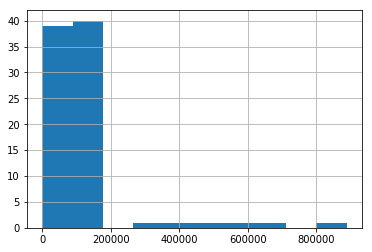

In [18]:
# Investigate patterns in the amount of missing data in each column.
nan_counts_per_column.hist()

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# By assesing from histogram there are 6 columns with missing data is the majority. 
# we can drop them
columns_majority_missing_filter = nan_counts_per_column[(nan_counts_per_column > 200000)]
columns_majority_missing_filter

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [20]:
azdias.drop(columns_majority_missing_filter.index.tolist(), axis=1, inplace=True)

In [21]:
azdias.isnull().sum(axis=0).hist()

As seen above remainging dataset columns (79 of them) max have 160K missing values. 

In [22]:
azdias.isnull().sum(axis=0).sort_values().plot(kind='bar', figsize=(15,10))

#### Discussion 1.1.2: Assess Missing Data in Each Column

- In the filtered dataset there are number of columns have very similar amount of missing cells, for example `PLZ8_ANTG1`, `PLZ8_ANTG2`, `PLZ8_ANTG3` and `PLZ8_ANTG4` have all same number of missing values. Thee are more columns following this pattern, may suggest there are confounding variables causing missing values pattern similarity. We can reduce number of features if one feature already gives a lot of information about the other similar features. We'll understand this better after we apply PCA. 


We removed the following columns in our dataset as they mostly have missing values. 
```
COLUMNS       MISSING COUNT
=========       ======
AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
```

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

rows_null = azdias.transpose().isnull().sum()

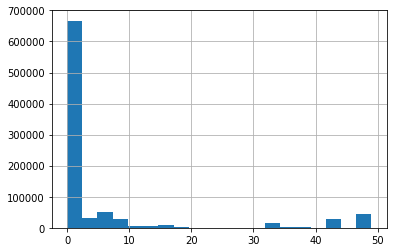

In [24]:
rows_null.hist(bins=20)

In [25]:
# It's a bit subjective decision but limiting the null values to be less than 10, discards 12% of the dataset.
# if i choose it to be 40 then I would discard 8%, not a huge difference, I then sacrifice a bit more data for 
# less amount of NaN in my dataset and go for 10. 
(rows_null>10).mean()

0.12462453196233034

In [26]:
(rows_null>40).mean()

0.083005225415469341

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

to_discard, to_keep = azdias.loc[rows_null>10], azdias.loc[rows_null<=10]

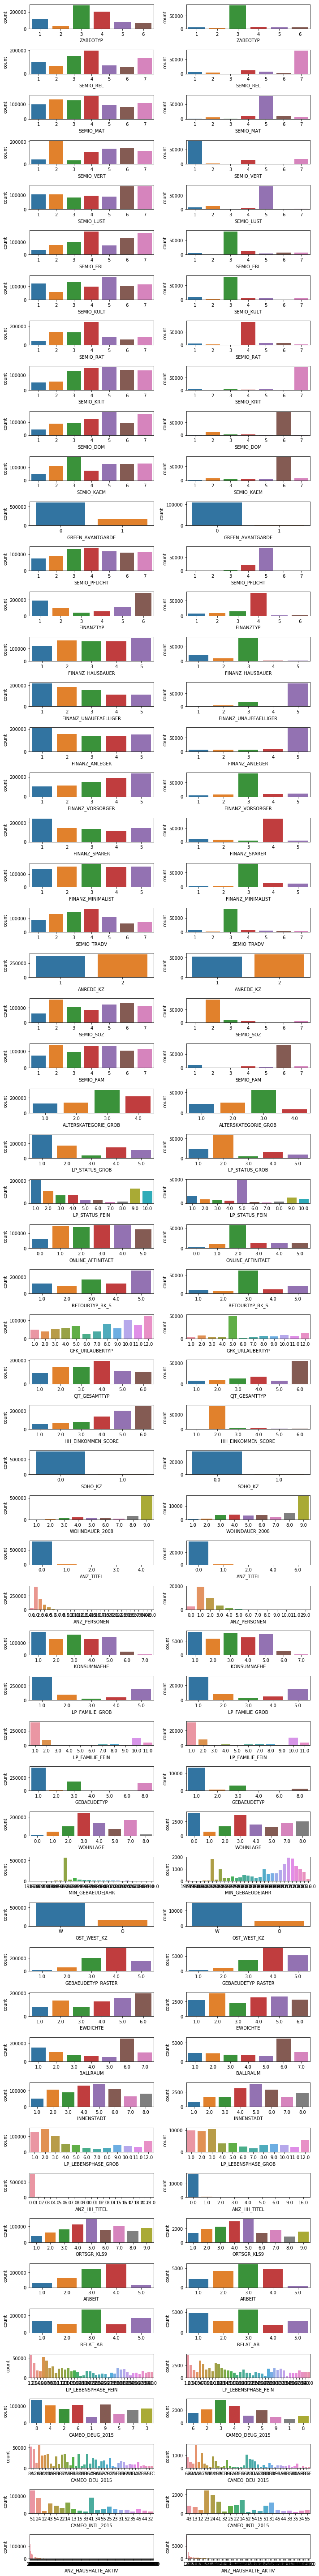

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# All features with small amount of NA count (<100000) in columns
feature_nacount = azdias.isnull().sum(axis=0).sort_values()
features = feature_nacount[feature_nacount < 100000].index.tolist()

def compare_features_plot(features):
    
    fig, axes = plt.subplots(len(features), 2, figsize=(10, 80))
    for i, feature in enumerate(features):
        sns.countplot(x=feature, data=to_keep, ax=axes[i, 0])
        sns.countplot(x=feature, data=to_discard, ax=axes[i, 1])
    plt.tight_layout()

compare_features_plot(features)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


**Ans: Graph above shows the countplot of all columns those have few or non NAs. By comparing side to side, we see a considerable difference between the rows we keep (if the NA count in that row is <10) and the rows we discard(NA>10).**

**I believe assumption of discarding rows with higher NA counts is not correct, as we see above dicarded rows probably have some intereting information.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?

feat_info.groupby(['type']).size().sort_values()

type
interval        1
numeric         3
mixed          11
categorical    26
ordinal        71
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info_backup[feat_info_backup['type'] == 'categorical']['attribute'].tolist()
only_categorical_cols = to_keep.filter(items=categorical)

In [31]:
categorical_properties = to_keep.filter(items=categorical).nunique().sort_values()
categorical_properties

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [32]:
# According to the chart above below are binary categorical features. 
# Note that OST_WEST_KZ is binary but not encoded in numbers, needs re-encoding
categorical_properties[categorical_properties == 2].index.tolist()

['ANREDE_KZ', 'OST_WEST_KZ', 'VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE']

In [33]:
# and the rest are multi level, so these needs to be re-encoded
categorical_properties[categorical_properties > 2].index.tolist()

['NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'LP_STATUS_GROB',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'ZABEOTYP',
 'CJT_GESAMTTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'LP_STATUS_FEIN',
 'LP_FAMILIE_FEIN',
 'GFK_URLAUBERTYP',
 'CAMEO_DEU_2015']

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Multi level categorical columns
multi_level = categorical_properties[categorical_properties > 2].index.tolist()

# Add also OST_WEST_KZ to this list as it is not encoded in number
multi_level.append('OST_WEST_KZ')


def do_onehotencoding(df, col_list):
    for col in col_list:
        df = pd.concat([df.drop(col, axis=1), 
                        pd.get_dummies(df[col], 
                                       prefix=col)], axis=1)
    return df

encoded_categorical = do_onehotencoding(to_keep, col_list=multi_level)

In [35]:
encoded_categorical.shape

(780153, 195)

In [36]:
encoded_categorical.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP      ...        CAMEO_DEU_2015_8B  \
1                 0         3.0      ...                        0   
2                 1         3.0      ...                        0   
3                 0         2.0      ...                        0   
4                 0         3.0      ...                        0   
5                 0         3.0      ...                        0   

   CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  \
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  1                  0                  0                  0   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  OST_WEST_KZ_O  \
1                  0                  0                  0              0   
2                  0                  0                  0              0   
3                  0                  0                  0              0   
4                  0                  0                  0              0   
5                  0                  0                  0              0   

   OST_WEST_KZ_W  
1              1  
2              1  
3              1  
4              1  
5              1  

[5 rows x 195 columns]

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Ans: there are 21 categorical variables and 5 of them are binary. Except `OST_WEST_KZ` other binary categorical variables were in numerical format. I therefore `onehotencoded` both all multi-level categorical variables as well as `OST_WEST_KZ`. Some multi-level categorical variables have many categories, such as  `CAMEO_DEU_2015` has 44 categories, I included in one hot encoding as I didn't want to drop it at this point. Later I'm planning to reduce  hight dimensions to lower dimensions (columns) after applying PCA. After Applting one-hot-encoding, I have now 195 columns.** 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Just to have an idea what mixed columsn are 

# mixed columns
mixed = feat_info_backup[feat_info_backup['type'] == 'mixed']['attribute'].tolist()
print(mixed)

# See how many levels each mixed variable has
to_keep.filter(items=mixed).nunique().sort_values()

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


PLZ8_BAUMAX               5
WOHNLAGE                  8
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
CAMEO_INTL_2015          21
LP_LEBENSPHASE_FEIN      40
dtype: int64

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# mainstream = 1 and avantgarde =0  
mainstream = [1, 3, 5, 8, 10, 12, 14]

decade_map = {
    1:40,
    2:40,
    3:50,
    4:50,
    5:60,
    6:60,
    7:60,
    8:70,
    9:70,
    10:80,
    11:80,
    12:80,
    13:80,
    14:90,
    15:90,
}

encoded_categorical['PJ_MAINSTREAM'] = encoded_categorical["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in mainstream else 0)
encoded_categorical['PJ_DECADE'] = encoded_categorical["PRAEGENDE_JUGENDJAHRE"].map(decade_map)


In [39]:
# Dataset isdominated by rather younger people, less data from people who were born in 40s and 50s 
encoded_categorical.groupby(by=['PJ_DECADE'])['PJ_DECADE'].count()

PJ_DECADE
40.0     27680
50.0     73441
60.0    113126
70.0    171875
80.0    148118
90.0    219439
Name: PJ_DECADE, dtype: int64

In [40]:
# There are 200K Avantgarde and 580K Mainstream tagged rows
encoded_categorical.groupby(by=['PJ_MAINSTREAM'])['PJ_MAINSTREAM'].count()

PJ_MAINSTREAM
0    198165
1    581988
Name: PJ_MAINSTREAM, dtype: int64

- X1: Pre-Family Couples & Singles
- X2: Young Couples With Children
- X3: Families With School Age Children
- X4: Older Families &  Mature Couples
- X5: Elders In Retirement

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
func_ls = lambda x: x if pd.isnull(x) else int(x)%10 
func_w = lambda x: x if pd.isnull(x) else int(x)//10

encoded_categorical['CI_2015_LIFE_STAGE'] = encoded_categorical["CAMEO_INTL_2015"].apply(func_ls)
encoded_categorical['CI_2015_WEALTH'] = encoded_categorical["CAMEO_INTL_2015"].apply(func_w)

In [42]:
# By looking at Life stage distribution Older families & singles have the most number of rows
encoded_categorical.groupby(by=['CI_2015_LIFE_STAGE'])['CI_2015_LIFE_STAGE'].count()

CI_2015_LIFE_STAGE
1.0    241777
2.0     75666
3.0    115411
4.0    228456
5.0    115187
Name: CI_2015_LIFE_STAGE, dtype: int64

- 1X: Wealthy Households
- 2X: Prosperous Households
- 3X: Comfortable Households
- 4X: Less Affluent Households
- 5X: Poorer Households

In [43]:
encoded_categorical.groupby(by=['CI_2015_WEALTH'])['CI_2015_WEALTH'].count()

CI_2015_WEALTH
1.0    116706
2.0    184575
3.0     66091
4.0    187271
5.0    221854
Name: CI_2015_WEALTH, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` are both related to wealth and Life stage and I believe we can drop them. Also I will drop `PLZ8_BAUMAX`, as I think `PLZ8_BAUMAX` is specific to a region. I decided to keep `WOHNLAGE` as it may be informative. 

**Dataset is dominated by rather younger people, less data is available from people who were born in 40s and 50s. 
There are also 200K Avantgarde and 580K Mainstream tagged rows**

**By looking at Life stage distribution Older families & singles have the most number of rows**

**Dataset has many wealthy and prosperous housholds, normally weath distribution should follow Zipf's law ,
but here there are more wealthy people than mid income people which either suggest germany is very successfull 
at keeping the gap small between poor and rich, or more likely our dataset has some bias :)**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# I reengineered `WOHNLAGE` and created two groups QUALITY and ISRURAL . I also dropped rows with value 0. 
# They are are only 3% and I think it doesn't have any predictive power.

# - -1: unknown
# -  0: no score calculated
# -  1: very good neighborhood
# -  2: good neighborhood
# -  3: average neighborhood
# -  4: poor neighborhood
# -  5: very poor neighborhood
# -  7: rural neighborhood
# -  8: new building in rural neighborhood
# encoded_categorical.groupby(by=['WOHNLAGE'])['WOHNLAGE'].count()

In [45]:
# drop fields with 0 
# encoded_categorical = encoded_categorical[encoded_categorical['WOHNLAGE'] != 0]

In [46]:
# rural = [7, 8]
# encoded_categorical['WOHNLAGE_ISRURAL'] = encoded_categorical["WOHNLAGE"].apply(lambda x: 1 if x in rural else 0)

In [47]:
# Let's encode the list as a categorical variable
# encoded_categorical = do_onehotencoding(encoded_categorical, col_list=['WOHNLAGE'])

In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# drop all mixed variables 
previously_dropped = set(columns_majority_missing_filter.index)
mixed_cols =  set(mixed)

to_drop = list(mixed_cols.difference(previously_dropped))

encoded_categorical.drop(to_drop, axis=1, inplace=True)

In [49]:
encoded_categorical.shape

(780153, 193)

In [50]:
# We keep the categorical variables (they are binary). Other categorial variables are one-hot-encoded
cols = encoded_categorical.columns
for each in categorical:
    if each in cols:
        print(each)

ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
VERS_TYP


In [51]:
# None of the mixed cols are kept as they are, few of them dropped, others re-engineered 

for each in mixed_cols:
    if each in cols:
        print(each)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('Converting NAs...{}'.format(df.shape))
    impute_na(df, feat_info)
    
    # remove selected columns and rows, ...
    print('Removing columns with high portion of NAs...{}'.format(df.shape))
#     nan_counts_per_column = df.isnull().sum(axis=0)
#     print(nan_counts_per_column.hist(bins=25))
    columns_majority_missing_filter = nan_counts_per_column[(nan_counts_per_column > 200000)]
    df.drop(columns_majority_missing_filter.index.tolist(), axis=1, inplace=True)
    
    # Removing rows with high NA values
    print('Removing rows with high portion of NAs...{}'.format(df.shape))
    rows_null = df.transpose().isnull().sum()
    to_keep =  df.loc[rows_null<=10]
    
    # select, re-encode, and engineer column values.
    print('One-hot-encoding categorical variables...{}'.format(to_keep.shape))
    categorical = feat_info_backup[feat_info_backup['type'] == 'categorical']['attribute'].tolist()
    only_categorical_cols = to_keep.filter(items=categorical)
    categorical_properties = to_keep.filter(items=categorical).nunique().sort_values()
    
    # Multi level categorical columns
    multi_level = categorical_properties[categorical_properties > 2].index.tolist()

    # Add also OST_WEST_KZ to this list as it is not encoded in number
    multi_level.append('OST_WEST_KZ')

    encoded_categorical = do_onehotencoding(to_keep, col_list=multi_level)
    
    # Work on mixed variables
    # mixed columns
    mixed = feat_info_backup[feat_info_backup['type'] == 'mixed']['attribute'].tolist()
    print('Working on Mixed variables...{}'.format(encoded_categorical.shape))
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    decade_map = {
        1:40,
        2:40,
        3:50,
        4:50,
        5:60,
        6:60,
        7:60,
        8:70,
        9:70,
        10:80,
        11:80,
        12:80,
        13:80,
        14:90,
        15:90,
    }

    encoded_categorical['PJ_MAINSTREAM'] = encoded_categorical["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in mainstream else 0)
    encoded_categorical['PJ_DECADE'] = encoded_categorical["PRAEGENDE_JUGENDJAHRE"].map(decade_map)
    print('Finsihed with PRAEGENDE_JUGENDJAHRE ...{}'.format(encoded_categorical.shape))
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    func_ls = lambda x: x if pd.isnull(x) else int(x)%10 
    func_w = lambda x: x if pd.isnull(x) else int(x)//10

    encoded_categorical['CI_2015_LIFE_STAGE'] = encoded_categorical["CAMEO_INTL_2015"].apply(func_ls)
    encoded_categorical['CI_2015_WEALTH'] = encoded_categorical["CAMEO_INTL_2015"].apply(func_w)
    print('Finsihed with CAMEO_INTL_2015 ...{}'.format(encoded_categorical.shape))
    
    encoded_categorical = encoded_categorical[encoded_categorical['WOHNLAGE'] != 0]
    
#     rural = [7, 8]
#     encoded_categorical['WOHNLAGE_ISRURAL'] = encoded_categorical["WOHNLAGE"].apply(lambda x: 1 if x in rural else 0)
    
#     map_q = {
#         1:5,  # Very good neighbourhood
#         2:4,  # good
#         3:3,  # average
#         4:2,  # poor
#         5:1,  # very poor
#         7:np.nan, # rural
#         8:np.nan, # new in rural
#     }

#     encoded_categorical['WOHNLAGE_QUALITY'] = encoded_categorical["WOHNLAGE"].map(map_q)
    
    # Let's encode the list as a categorical variable
#     encoded_categorical = do_onehotencoding(encoded_categorical, col_list=['WOHNLAGE'])
#     print('Finsihed with WOHNLAGE ...{}'.format(encoded_categorical.shape))
    
    
    # dropped original mixed variables
    previously_dropped = set(columns_majority_missing_filter.index)
    mixed_cols =  set(mixed)

    to_drop = list(mixed_cols.difference(previously_dropped))

    encoded_categorical.drop(to_drop, axis=1, inplace=True)
    print('Finished dropping mixed variables..{}'.format(encoded_categorical.shape))
    
    # Return the cleaned dataframe.
    return encoded_categorical
    
df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [53]:
customer_df = clean_data(df)

Converting NAs...(191652, 85)
Removing columns with high portion of NAs...(191652, 85)
Removing rows with high portion of NAs...(191652, 79)
One-hot-encoding categorical variables...(139068, 79)
Working on Mixed variables...(139068, 194)
Finsihed with PRAEGENDE_JUGENDJAHRE ...(139068, 196)
Finsihed with CAMEO_INTL_2015 ...(139068, 198)
Finished dropping mixed variables..(138507, 192)


In [54]:
clean_df.shape

(138507, 192)

In [55]:
df = clean_data(azdias_backup)

Converting NAs...(891221, 85)
Removing columns with high portion of NAs...(891221, 85)
Removing rows with high portion of NAs...(891221, 79)
One-hot-encoding categorical variables...(780153, 79)
Working on Mixed variables...(780153, 195)
Finsihed with PRAEGENDE_JUGENDJAHRE ...(780153, 197)
Finsihed with CAMEO_INTL_2015 ...(780153, 199)
Finished dropping mixed variables..(777199, 193)


In [56]:
df.shape

(777199, 193)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

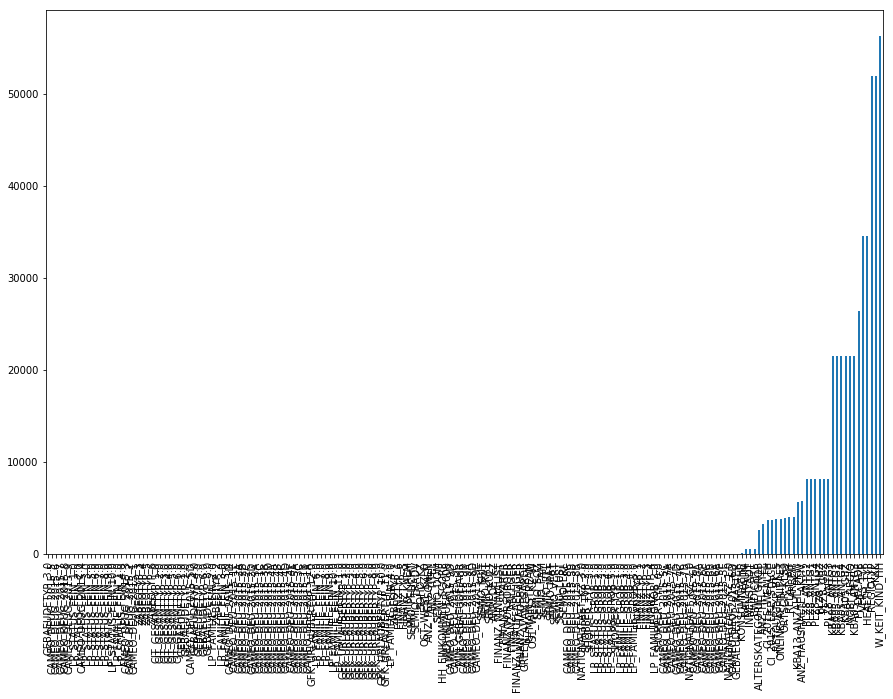

In [57]:
df.isnull().sum(axis=0).sort_values().plot(kind='bar', figsize=(15,10))

In [58]:
# If we simply drop rows containin NA values, then we would throw 25% of all data 
# Therefore I want to do it another way
df.dropna().shape

(623207, 193)

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Let's impute the 'most_frequent' values as taking mean or median for categorical 
# variables may not make too much sense
from sklearn.preprocessing import Imputer, StandardScaler

scaler = StandardScaler()
imputer = Imputer(strategy='most_frequent',axis=0)

scaled = scaler.fit_transform(imputer.fit_transform(df))

In [ ]:
# below, is a method to apply scaling with ommiting NaNs however it's very slow,
# so I abandoned this method, but for reference I keep it.

# from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler(feature_range=(0, 1))

# def scale_with_nan(df, scaler):
#     l = len(df.columns)
#     for i, col in enumerate(df.columns):
#         null_index = df[col].isnull()
#         df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
        
#         percent = np.round(i/l*100, 2)
#         print('{}% completed ..'.format(percent), end="\r", flush=True)
#     return df

# scaled = scale_with_nan(df, scaler)

In [60]:
# Apply feature scaling to the general population demographics data.
scaled

array([[-1.76795854,  0.95838069, -1.48639057, ...,  1.10614313,
        -1.2485484 ,  1.1681218 ],
       [ 0.19750366,  0.95838069, -1.48639057, ...,  1.10614313,
         0.76331617, -0.87652894],
       [ 1.18023476,  0.95838069,  0.69053803, ..., -0.25829569,
        -0.57792688, -1.55807919],
       ..., 
       [-0.78522744,  0.95838069, -0.76074771, ...,  1.10614313,
         0.76331617, -0.87652894],
       [-1.76795854, -1.0434267 , -1.48639057, ...,  1.10614313,
        -1.2485484 ,  1.1681218 ],
       [ 1.18023476, -1.0434267 ,  0.69053803, ..., -1.62273452,
         0.09269465,  0.48657156]])

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Before scaling I had to tackle the missing data issue as scaling wouldn't work  with missing data. When I dropped all rows with misisng data then I would end up losing 25% of all data. 

I decided to impute. There are three options to pick when it comes to use `sklearn.preprocessing Imputer`
options like `mean` and `median` doesn't make sense for categorical variables therefore I imputed missing values with `mode`, most frequently occurung value. 

As seen in the missing values per column graph above only few number of columns has missing data, so this imputation hopefully won't have drastic impact on my result. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [62]:
# Investigate the variance accounted for by each principal component.

# I shamelessly copied the scree plot function from the excercises to visualize the explained variance PCA component

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), 
                    va="bottom", ha="center", fontsize=12, rotation=90)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

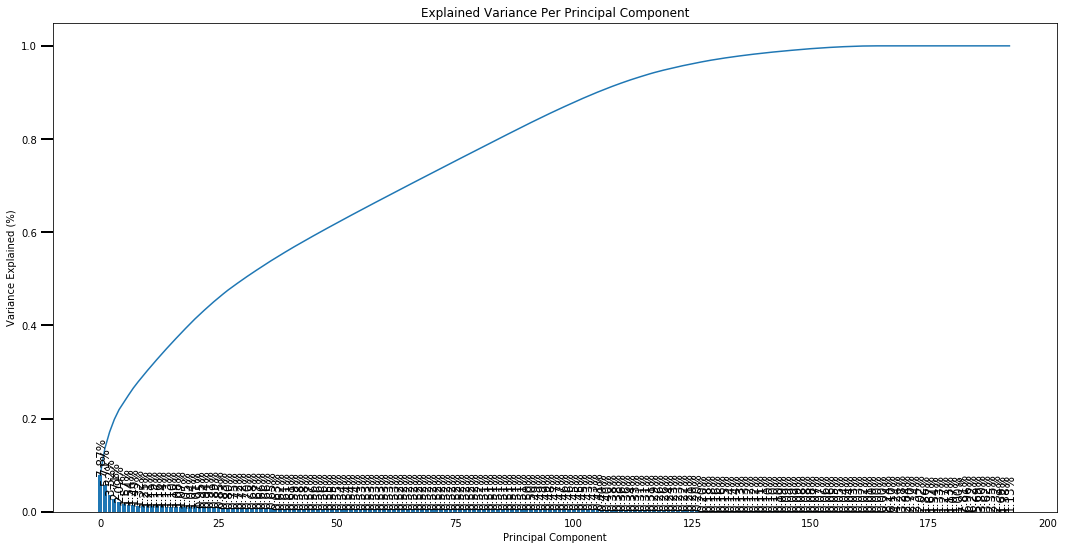

In [63]:
scree_plot(pca)

In [64]:
np.sum(pca.explained_variance_ratio_[:90])


0.82537852334945061

In [65]:
# Re-apply PCA to the data while selecting for number of components to retain.

# I chose PCA of 90 as it explains about 82% of variance and might be a good trade off, 
# going from ~200 columns to 90 columns

pca = PCA(n_components=90)
X_pca = pca.fit_transform(scaled)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


By looking at scree plot, I decided to go for about 90 dimensions as it can explain about ~82% of the variance. Going from ~200 dimensions to 90 dimensions is an improvement. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


# pca_results function was also defined in the PCA section of the course, reusing it here, with removing plot section

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

weight_map = pca_results(full_dataset=df, pca=pca)

In [67]:
c1 = weight_map.transpose()['Dimension 1']
c1.sort_values(ascending=False)

LP_STATUS_GROB_1.0      0.1961
HH_EINKOMMEN_SCORE      0.1854
CI_2015_WEALTH          0.1847
PLZ8_ANTG3              0.1822
PLZ8_ANTG4              0.1753
ORTSGR_KLS9             0.1543
EWDICHTE                0.1523
FINANZ_HAUSBAUER        0.1478
KBA05_ANTG4             0.1288
LP_STATUS_FEIN_1.0      0.1251
PLZ8_ANTG2              0.1244
FINANZ_SPARER           0.1211
LP_STATUS_FEIN_2.0      0.1182
KBA05_ANTG3             0.1171
FINANZTYP_1             0.1162
ANZ_HAUSHALTE_AKTIV     0.1154
ARBEIT                  0.1142
CAMEO_DEUG_2015_9       0.1139
RELAT_AB                0.1068
CAMEO_DEUG_2015_8       0.0920
PJ_MAINSTREAM           0.0886
SEMIO_PFLICHT           0.0885
LP_FAMILIE_FEIN_1.0     0.0861
LP_FAMILIE_GROB_1.0     0.0861
SEMIO_REL               0.0842
PJ_DECADE               0.0841
Explained Variance      0.0787
ZABEOTYP_5              0.0786
SEMIO_RAT               0.0743
GEBAEUDETYP_3.0         0.0671
                         ...  
WOHNDAUER_2008         -0.0559
SEMIO_LU

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_map.transpose()['Dimension 2'].sort_values(ascending=False)

ALTERSKATEGORIE_GROB     0.2310
FINANZ_VORSORGER         0.2159
ZABEOTYP_3               0.1997
SEMIO_ERL                0.1798
SEMIO_LUST               0.1606
RETOURTYP_BK_S           0.1555
W_KEIT_KIND_HH           0.1221
CJT_GESAMTTYP_2.0        0.1066
LP_STATUS_FEIN_1.0       0.1016
FINANZTYP_5              0.0974
FINANZ_HAUSBAUER         0.0899
FINANZTYP_2              0.0879
FINANZ_MINIMALIST        0.0828
SHOPPER_TYP_3.0          0.0765
SEMIO_KRIT               0.0756
PLZ8_ANTG3               0.0731
CJT_GESAMTTYP_1.0        0.0703
EWDICHTE                 0.0694
ORTSGR_KLS9              0.0687
PLZ8_ANTG4               0.0684
FINANZTYP_6              0.0672
NATIONALITAET_KZ_1.0     0.0659
CI_2015_WEALTH           0.0644
LP_FAMILIE_GROB_1.0      0.0616
LP_FAMILIE_FEIN_1.0      0.0616
SEMIO_KAEM               0.0595
GFK_URLAUBERTYP_4.0      0.0591
Explained Variance       0.0572
KBA05_ANTG4              0.0564
ARBEIT                   0.0540
                          ...  
INNENSTA

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_map.transpose()['Dimension 3'].sort_values(ascending=False)

SEMIO_VERT               0.3209
SEMIO_FAM                0.2611
SEMIO_SOZ                0.2582
SEMIO_KULT               0.2508
FINANZTYP_5              0.1358
FINANZ_MINIMALIST        0.1292
SHOPPER_TYP_0.0          0.1243
ZABEOTYP_1               0.1155
SEMIO_REL                0.1139
SEMIO_MAT                0.0883
RETOURTYP_BK_S           0.0761
GREEN_AVANTGARDE         0.0719
W_KEIT_KIND_HH           0.0624
EWDICHTE                 0.0621
ORTSGR_KLS9              0.0621
SHOPPER_TYP_1.0          0.0507
ZABEOTYP_6               0.0505
LP_STATUS_GROB_5.0       0.0500
LP_STATUS_FEIN_10.0      0.0500
PLZ8_ANTG3               0.0487
PLZ8_ANTG4               0.0485
FINANZ_VORSORGER         0.0469
LP_STATUS_FEIN_1.0       0.0451
LP_STATUS_FEIN_3.0       0.0440
PLZ8_ANTG2               0.0353
Explained Variance       0.0353
RELAT_AB                 0.0343
ARBEIT                   0.0330
LP_STATUS_GROB_3.0       0.0320
GEBAEUDETYP_3.0          0.0306
                          ...  
LP_STATU

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Largest positive and negative weights for the 1st PC are : 
```
LP_STATUS_GROB_1.0      0.1961
MOBI_REGIO             -0.1944
```

Largest positive and negative weights for the 2nd PC are : 
```
ALTERSKATEGORIE_GROB     0.2310
PJ_DECADE               -0.2289
```

Largest positive and negative weights for the 3rd PC are : 
```
SEMIO_VERT               0.3209
ANREDE_KZ               -0.3463
```

weight maps for each PCs are eigenvectors. And the weight associated for each variable shows how strongly it affects the PC for that PC. For example `LP_STATUS_GROB_1.0` has the most affect for the first PC. Weights with high scores on the variables with negative effect tends to have lower component scores. 

Ref: https://www.researchgate.net/post/what_negative_sign_mean_in_PCA

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [70]:
from sklearn.cluster import KMeans, MiniBatchKMeans

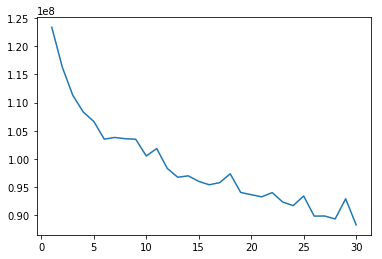

In [71]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


def elbow(data, n_clusters_max=30):
    centers = np.arange(1,n_clusters_max + 1)
    scores = np.zeros(n_clusters_max)
    for i in range(0, n_clusters_max):
        kmeans = MiniBatchKMeans(n_clusters=i+1)
        model = kmeans.fit(data)
        scores[i] = np.abs(model.score(data))
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(centers, scores)
    return centers, scores

centers, scores = elbow(X_pca)

In [72]:
# Visually inspecting is not where clear where elbow happens, If i need to guess, I would say it's around 12 groups.  

list(zip(centers, scores))

[(1, 123368015.89826524),
 (2, 116291495.04820223),
 (3, 111294177.5995273),
 (4, 108321600.0610497),
 (5, 106658684.42857553),
 (6, 103521511.46534277),
 (7, 103817604.18792076),
 (8, 103595186.67824438),
 (9, 103495925.45985767),
 (10, 100534868.65406437),
 (11, 101847015.99237755),
 (12, 98332108.025134921),
 (13, 96754031.052731961),
 (14, 97007573.143745288),
 (15, 96028599.38264668),
 (16, 95422772.503754988),
 (17, 95803674.692459077),
 (18, 97367866.000517383),
 (19, 94057652.507184193),
 (20, 93662737.892102316),
 (21, 93279692.015966699),
 (22, 94032595.593278363),
 (23, 92363476.471859217),
 (24, 91726573.715486869),
 (25, 93436581.215507001),
 (26, 89867571.055947572),
 (27, 89881576.583325163),
 (28, 89362381.008054793),
 (29, 92939542.696292892),
 (30, 88301688.4339744)]

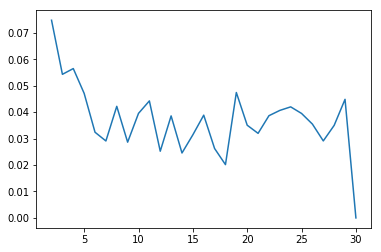

In [73]:
# Just to use another way to see if I pick correctly n_clusters, I ran silhouette_score. 
# But not much luck here either.

from sklearn.metrics import silhouette_score

def silhouette(data, n_clusters_max=30):
    centers = np.arange(2,n_clusters_max + 1)
    scores = np.zeros(n_clusters_max-1)
    for i in range(2, n_clusters_max):
        kmeans = MiniBatchKMeans(n_clusters=i)
        model = kmeans.fit(data)
        labels = model.fit_predict(data)
        scores[i-2] = silhouette_score(data, labels, sample_size=10000)
        print('Processed cluster {}'.format(i), end="\r", flush=True)
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(centers, scores)
    return centers, scores

centers, scores = silhouette(X_pca)

In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X_pca)


In [130]:
# Get predicted labels
labels = kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)


I tried two methods to decide for ideal number of clusters. First one was `elbow` method and the second one was `silhouette_score`. I ran `KMeans` (Actually `MiniBatchKMeans` for speed) from two clusters to thirty clusters and looked at scores. However there wasn't a really clear point to choose the cluster numbers. But by looking elbow graph I decided to go for 12 clusters so I trained KMeans with 12 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [125]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer

def feature_transform_and_cluster(data):
    """
    Apply feature transformation, PCA
    """
    
    # Impute missing values + scale columns
    scaler = StandardScaler()
    imputer = Imputer(strategy='most_frequent',axis=0)

    scaled = scaler.fit_transform(imputer.fit_transform(data))
    
    
    # Apply PCA feature transformation
    pca = PCA(n_components=90)
    X_pca = pca.fit_transform(scaled)
    
    
    # Apply clustering
    kmeans = KMeans(n_clusters=12)
    labels = kmeans.fit_predict(X_pca)
    
    return labels, X_pca, pca, scaler, kmeans
    

In [126]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers = clean_data(customers)

labels_customer, data_customer, pca_cust, scaler_cust, kmeans_cust = feature_transform_and_cluster(customers)

Converting NAs...(191652, 85)
Removing columns with high portion of NAs...(191652, 85)
Removing rows with high portion of NAs...(191652, 79)
One-hot-encoding categorical variables...(139068, 79)
Working on Mixed variables...(139068, 194)
Finsihed with PRAEGENDE_JUGENDJAHRE ...(139068, 196)
Finsihed with CAMEO_INTL_2015 ...(139068, 198)
Finished dropping mixed variables..(138507, 192)


In [127]:
general = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
general = clean_data(general)

labels_general, data_general, pca_general, scaler_general, kmeans_general = feature_transform_and_cluster(general)

Converting NAs...(891221, 85)
Removing columns with high portion of NAs...(891221, 85)
Removing rows with high portion of NAs...(891221, 79)
One-hot-encoding categorical variables...(780153, 79)
Working on Mixed variables...(780153, 195)
Finsihed with PRAEGENDE_JUGENDJAHRE ...(780153, 197)
Finsihed with CAMEO_INTL_2015 ...(780153, 199)
Finished dropping mixed variables..(777199, 193)


In [128]:
# Check distribution of labels
sns.countplot(labels_customer)

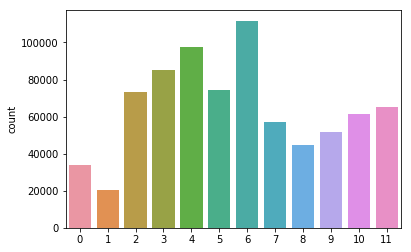

In [129]:
sns.countplot(labels_general)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

<function matplotlib.pyplot.show(*args, **kw)>

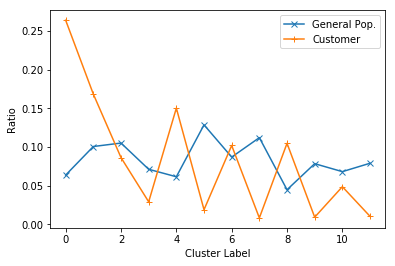

In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def get_ratio(l):
    clusters, counts = np.unique(l, return_counts=True)
    ratios = counts/len(l)
    
    return clusters, ratios

clusters_general, ratios_general = get_ratio(labels)
clusters_customer, ratios_customer = get_ratio(labels_customer)

plt.plot(clusters_general, ratios_general, "x-", label="General Pop.")
plt.plot(clusters_customer, ratios_customer, "+-", label="Customer")
plt.legend()
plt.xlabel('Cluster Label')
plt.ylabel('Ratio')
plt.show

In [156]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

nonscaled = pca_general.inverse_transform(kmeans_general.cluster_centers_)
original = scaler_general.inverse_transform(nonscaled)
original_df = pd.DataFrame(original, columns=general.columns)

overrepresented = original_df.iloc[0]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(overrepresented)

ALTERSKATEGORIE_GROB        2.973015
ANREDE_KZ                   1.430581
FINANZ_MINIMALIST           3.838476
FINANZ_SPARER               2.264130
FINANZ_VORSORGER            3.635601
FINANZ_ANLEGER              2.551753
FINANZ_UNAUFFAELLIGER       2.431226
FINANZ_HAUSBAUER            2.509894
GREEN_AVANTGARDE            0.466078
HEALTH_TYP                  2.221994
RETOURTYP_BK_S              3.559282
SEMIO_SOZ                   4.281100
SEMIO_FAM                   4.079265
SEMIO_REL                   3.759217
SEMIO_MAT                   3.800254
SEMIO_VERT                  4.743716
SEMIO_LUST                  4.634979
SEMIO_ERL                   4.611412
SEMIO_KULT                  4.184453
SEMIO_RAT                   3.650560
SEMIO_KRIT                  4.190165
SEMIO_DOM                   4.403148
SEMIO_KAEM                  3.913399
SEMIO_PFLICHT               3.854574
SEMIO_TRADV                 3.574648
SOHO_KZ                     0.026118
VERS_TYP                    1.529076
A

In [159]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented = original_df.iloc[5]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(underrepresented)

ALTERSKATEGORIE_GROB        3.251214
ANREDE_KZ                   1.047001
FINANZ_MINIMALIST           3.300211
FINANZ_SPARER               1.867545
FINANZ_VORSORGER            4.327705
FINANZ_ANLEGER              1.475670
FINANZ_UNAUFFAELLIGER       1.763720
FINANZ_HAUSBAUER            3.583610
GREEN_AVANTGARDE            0.117383
HEALTH_TYP                  2.318057
RETOURTYP_BK_S              4.511712
SEMIO_SOZ                   5.222985
SEMIO_FAM                   5.201269
SEMIO_REL                   3.940424
SEMIO_MAT                   4.208319
SEMIO_VERT                  5.864260
SEMIO_LUST                  5.013535
SEMIO_ERL                   4.139364
SEMIO_KULT                  5.034891
SEMIO_RAT                   2.726053
SEMIO_KRIT                  3.692306
SEMIO_DOM                   3.372966
SEMIO_KAEM                  2.906280
SEMIO_PFLICHT               3.450455
SEMIO_TRADV                 3.044583
SOHO_KZ                     0.010600
VERS_TYP                    1.640889
A

In [163]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(overrepresented[abs(overrepresented - underrepresented) > 0.8])

FINANZ_ANLEGER            2.551753
FINANZ_HAUSBAUER          2.509894
RETOURTYP_BK_S            3.559282
SEMIO_SOZ                 4.281100
SEMIO_FAM                 4.079265
SEMIO_VERT                4.743716
SEMIO_KULT                4.184453
SEMIO_RAT                 3.650560
SEMIO_DOM                 4.403148
SEMIO_KAEM                3.913399
ANZ_PERSONEN              2.438292
HH_EINKOMMEN_SCORE        3.295929
W_KEIT_KIND_HH            3.734193
ANZ_HAUSHALTE_AKTIV       1.584958
KONSUMNAEHE               3.175111
MIN_GEBAEUDEJAHR       1993.467787
KBA05_ANTG1               2.027825
KBA05_GBZ                 3.916853
BALLRAUM                  4.508754
EWDICHTE                  3.454310
INNENSTADT                4.995018
MOBI_REGIO                3.663035
ONLINE_AFFINITAET         3.441140
KBA13_ANZAHL_PKW        661.745287
PLZ8_ANTG1                2.607234
PLZ8_ANTG3                1.200170
ORTSGR_KLS9               4.673256
RELAT_AB                  2.793464
LP_STATUS_GROB_3.0  

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


Segment of population rather overrepresneted (popular) with mail company:
 * Prosperous Households - Families With School Age Children
 * with family orientation movement (PRAEGENDE_JUGENDJAHRE)
 * rather living in small community (ORTSGR_KLS9)
 * with indepenedent social status (LP_STATUS_GROB)
 * with higher affinity
 * incentive-receptive (RETOURTYP_BK_S)
 * high income (HH_EINKOMMEN_SCORE)
 * high online affinity (ONLINE_AFFINITAET)
 
Segment of population rather underrepresented (unpopular) with mail company:
 * Less Affluent Households - Young Couples With Children
 * living in middle-big communities.
 * with lightly less affinity
 * more conservative to influence (RETOURTYP_BK_S)
 * lower income (HH_EINKOMMEN_SCORE)
 * lower online affinity (ONLINE_AFFINITAET)
 
 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.